In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor

### Задание 1

Загрузим данные и проведём первичный анализ.

In [2]:
data = pd.read_csv("train.csv")

Т.к. датасет имеет большое количество столбцов, то ограничимся лишь теми, которые имеют большую корреляцию с параметром SalePrice.

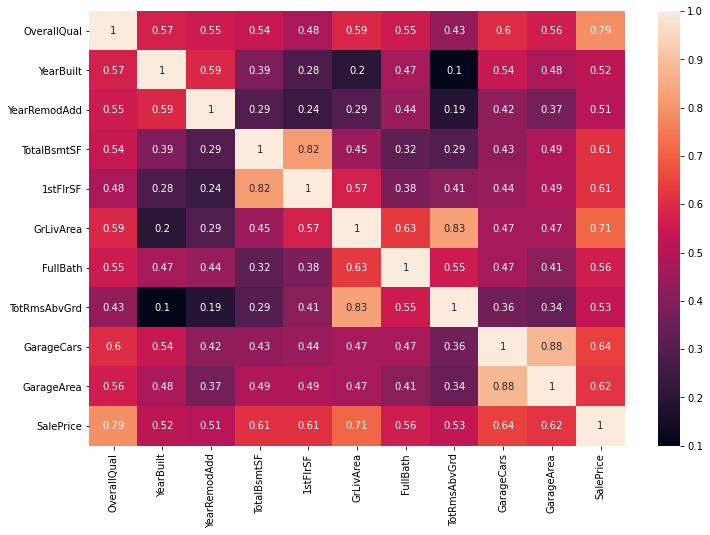

In [3]:
values_greater_05 = data.corr().SalePrice[(data.corr().SalePrice > 0.5)]
columns_greater_05 = list(values_greater_05.index.values)

plt.figure(figsize = (12, 8))
sns.heatmap(data[columns_greater_05].corr().round(2), annot = True)
plt.show()

In [4]:
data[values_greater_05.index.values].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   OverallQual   1460 non-null   int64
 1   YearBuilt     1460 non-null   int64
 2   YearRemodAdd  1460 non-null   int64
 3   TotalBsmtSF   1460 non-null   int64
 4   1stFlrSF      1460 non-null   int64
 5   GrLivArea     1460 non-null   int64
 6   FullBath      1460 non-null   int64
 7   TotRmsAbvGrd  1460 non-null   int64
 8   GarageCars    1460 non-null   int64
 9   GarageArea    1460 non-null   int64
 10  SalePrice     1460 non-null   int64
dtypes: int64(11)
memory usage: 125.6 KB


Как видно, наш ограниченный датасет состоит из цифровых столбцов и не имеет нулевых значений.

In [5]:
X = data[["OverallQual", "YearBuilt", "YearRemodAdd", "TotalBsmtSF", "1stFlrSF", "GrLivArea", "FullBath", "TotRmsAbvGrd",
          "GarageCars", "GarageArea"]]
Y = data["SalePrice"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

#### Случайный лес

In [6]:
model_rfr = RandomForestRegressor()
model_rfr.fit(X_train, Y_train)

RandomForestRegressor()

Для оценки модели случайного леса применим кросс-валидацию.

In [7]:
print("CV Score:", round(np.mean(cross_val_score(model_rfr, X, Y, cv = 10)), 4))

CV Score: 0.8376


Выведем важность признаков.

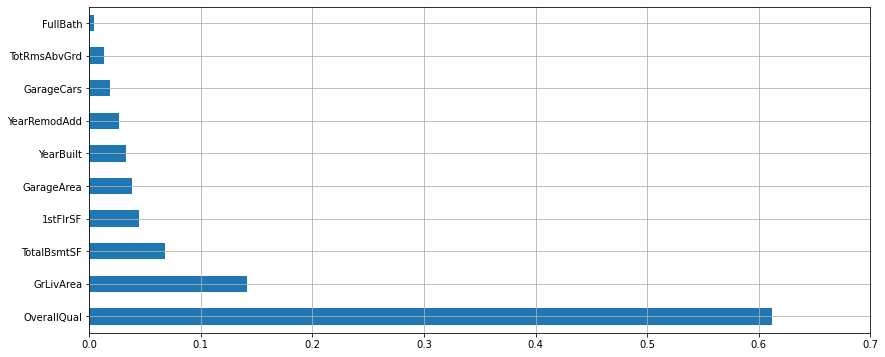

In [8]:
plt.figure(figsize = (14, 6))

df = (pd.Series(model_rfr.feature_importances_, index = X.columns))
df.nlargest(10).plot(kind = "barh")

plt.xlim(0, 0.7)

plt.grid()
plt.show()

#### Стекинг

В качестве базовых классификаторов выберем линейную регрессию, регрессию LASSO и алгоритм решающего дерева. Обобщающим алгоритмом будет модель случайного леса.

In [9]:
estimators = [
    ("lr", LinearRegression()), 
    ("lso", LassoCV()),
    ("dtr", DecisionTreeRegressor())
]

model_sr = StackingRegressor(estimators = estimators, final_estimator = RandomForestRegressor())
model_sr.fit(X_train, Y_train)

StackingRegressor(estimators=[('lr', LinearRegression()), ('lso', LassoCV()),
                              ('dtr', DecisionTreeRegressor())],
                  final_estimator=RandomForestRegressor())

Для оценки нашей модели применим Hold-out метод.

In [10]:
print("Train Score:", round(model_sr.score(X_train, Y_train), 4))
print("Test Score:", round(model_sr.score(X_test, Y_test), 4))

Train Score: 0.91
Test Score: 0.86


Несмотря на то что модель случайного леса показала хороший результат, ансамбль моделей всё равно победил.